# Louis George    

## Modeling

In [167]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation

from xgboost import XGBClassifier

import joblib

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [168]:
plt.rc('ytick', labelsize=15)

### Reading in the data

In [169]:
X_train_tfidf = pd.read_csv('../../data/X_train_tfidf.csv')
X_test_tfidf = pd.read_csv('../../data/X_test_tfidf.csv')

In [170]:
X_train_countv = pd.read_csv('../../data/X_train_countv.csv')
X_test_countv = pd.read_csv('../../data/X_test_countv.csv')

In [171]:
y_imdb_train = pd.read_csv('../../data/y_imdb_train.csv')
y_rt_train = pd.read_csv('../../data/y_rt_train.csv')
y_profit_train = pd.read_csv('../../data/y_profit_train.csv')

y_imdb_test = pd.read_csv('../../data/y_imdb_test.csv')
y_rt_test = pd.read_csv('../../data/y_rt_test.csv')
y_profit_test = pd.read_csv('../../data/y_profit_test.csv')

### Exploring the possibility of using Latent Dirichlet Allocation for decomposition      

Due to the differences in scale between the genre dummies, part of speech counts, and word vectors, I will use only the word vectors. Scaling is not required when modeling using the full data set with Logistic Regression and Decision Tree based models, so this won't be an issue going forward.

In [37]:
X_train_countv_vecs = X_train_countv.iloc[:, 28:]
X_test_countv_vecs = X_test_countv.iloc[:, 28:]

topic_num = [3, 5, 10, 20]

train_scores = []
test_scores = []

for i in topic_num:
    lda = LatentDirichletAllocation(n_components=i).fit(X_train_countv_vecs)
    lda_train_weights = lda.transform(X_train_countv_vecs)
    lda_test_weights = lda.transform(X_test_countv_vecs)
    
    logreg = LogisticRegression().fit(lda_train_weights, y_imdb_train)
    train_scores.append(logreg.score(lda_train_weights, y_imdb_train))
    test_scores.append(logreg.score(lda_test_weights, y_imdb_test))

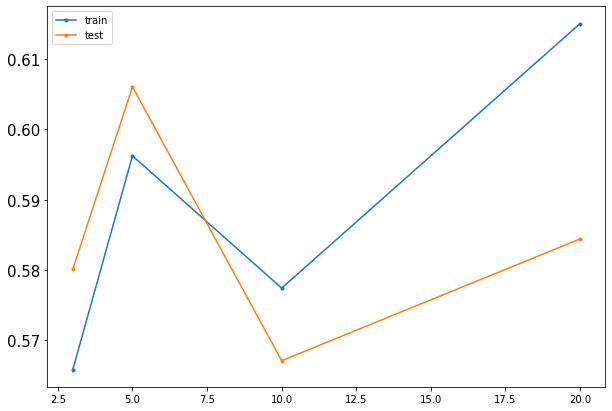

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(topic_num, train_scores, marker='.', label='train')
plt.plot(topic_num, test_scores, marker='.', label='test')
plt.legend()

As we can see from this graph, LDA decomposition is not going to give us any good results. For fun, let's see what the topics look like for one of the more reasonable results:

In [30]:
# Function which shows the features with the highest coefficients for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# This function is courtesy of the sklearn documentation @:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [43]:
topic_num = 20

lda = LatentDirichletAllocation(n_components=topic_num).fit(X_train_countv_vecs)

n_top_words = 20
feature_names = X_train_countv_vecs.columns

print_top_words(lda, feature_names, n_top_words)

Topic #0: paul david doc al buzz prince phone kitchen vanity mr hotel laser beloved family baby van child truck toy road
Topic #1: ship gun angle bobby blood shadow control rock space tree continue continue slam deck storm climb wind edge star cont'd to
Topic #2: sam ed richard stark cat cont'd wade child pete v.o mr truck father office dr ok william to phone o.s
Topic #3: george max larry bill pat henry mr yeah cont'd okay bush hooker camera money to crash uncle mrs office bank
Topic #4: horse louis father cont'd child mr king sir mrs lord lady james sword ride dance tree crowd william v.o wife
Topic #5: cont'd guy yeah to fuck eddie go to phone okay shit ben fucking pete continue continue continuous bobby money o.s whip dave
Topic #6: mike e t s o c d n r b h m l lincoln g f x y u ashe
Topic #7: charlie harry michael mr phone okay apartment mrs bedroom book office kitchen desk cont'd pause yeah school music dr living
Topic #8: frank mary tom bob grace precious jim sheriff rain robert

It's pretty hard to make any sense of this many topics. Ideally it would have resulted in topics which could be distinguished as genres, but it isn't super obvious.    

Moving forward, we'll focus on tf-idf.

In [147]:
targets = [['IMDb', y_imdb_train, y_imdb_test], 
           ['Rotten Tomatoes', y_rt_train, y_rt_test], 
           ['Profit Margin', y_profit_train, y_profit_test]]

In [148]:
def log_modeler(targets):
    
    scores = []
    
    for source, y_train, y_test in targets:
        # Pipeline
        estimators = [('model', LogisticRegression())]

        pipe = Pipeline(estimators)

        # Grid search
        param_grid = [{'model':[LogisticRegression()],
                       'model__penalty':['l1', 'l2'],
                       'model__C':np.logspace(-2, 2, 5, 10)}]

        grid = GridSearchCV(pipe, param_grid, cv=5)
        logreg_best = grid.fit(X_train_tfidf, y_train)

        # Taking params from best model because we will need the coefficients
        C_val = logreg_best.best_params_['model__C']
        penalty_val = logreg_best.best_params_['model__penalty']

        # Refitting the model so that we have the normal methods available
        logreg = LogisticRegression(C=C_val, penalty=penalty_val).fit(X_train_tfidf, y_train)
        
        # Pickling the model
        joblib.dump(logreg, f'../models/{source.split()[0]}_logreg.pkl')
        
        # Saving the scores
        scores.append([logreg.score(X_train_tfidf, y_train), logreg.score(X_test_tfidf, y_test)])

        # Creating a dataframe to compare the coefficient values
        lr_coefs = pd.DataFrame({'Coef':X_train_tfidf.columns,
                                 'Value':logreg.coef_[0]})
        lr_t10 = lr_coefs.sort_values(by='Value', ascending=False).head(10)

        # Plotting the results
        plt.figure(figsize=(12,7))
        plt.barh(lr_t10['Coef'], abs(lr_t10['Value']))
        plt.title(f"Features with the Highest Coefficient \n {source} Logistic Regression")
        plt.xlabel("Coefficient Value")
        plt.savefig(f"../plots/{source.split()[0]}_logreg.png");
    
    return scores

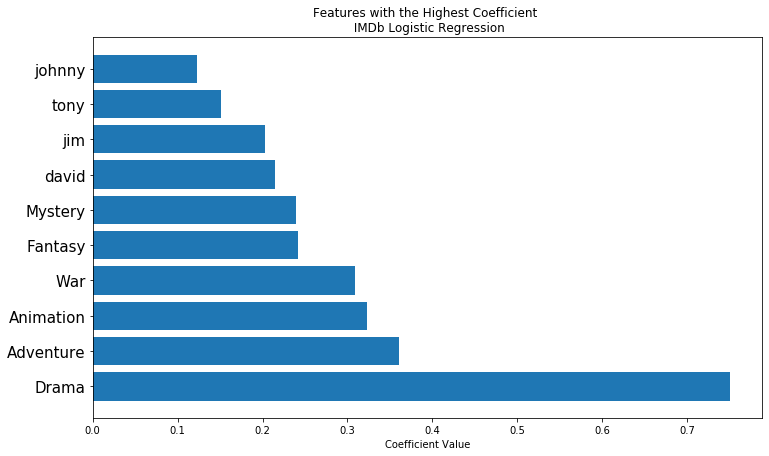

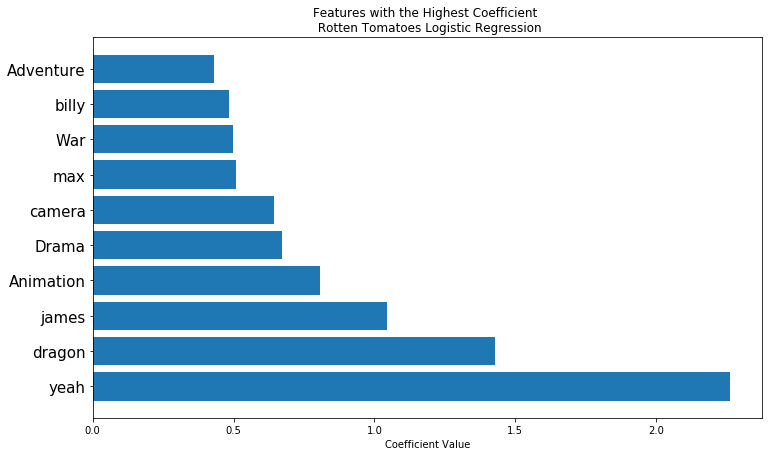

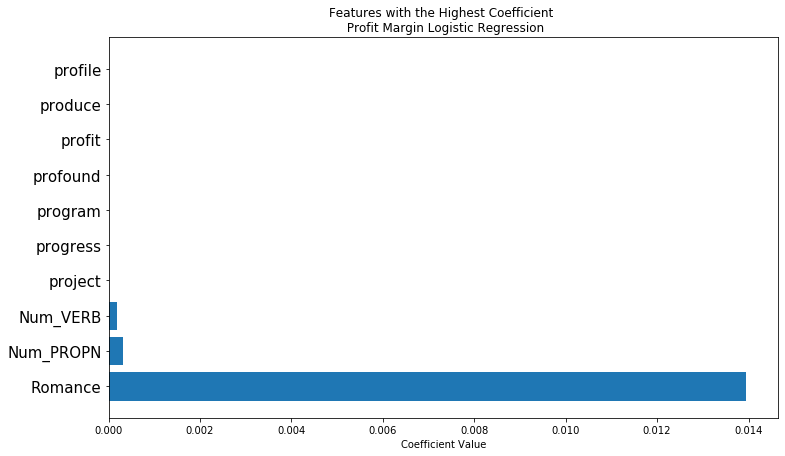

In [149]:
logreg_scores = log_modeler(targets)

In [150]:
logreg_scores

[[0.6714905933429812, 0.6320346320346321],
 [0.6874095513748191, 0.5584415584415584],
 [0.5947901591895803, 0.6277056277056277]]

In [160]:
logreg_profit = joblib.load('../models/Rotten_logreg.pkl')

In [161]:
logreg_profit.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)>

Weird results with the l1 penalty. Results in a higher test score than training for Profit. Also it's a v shit result maybe less than random.

In [164]:
def xgbc_modeler(targets):
    
    scores = []
    
    for source, y_train, y_test in targets:
        
        # Pipeline
        estimators = [('model', XGBClassifier())]
        pipe = Pipeline(estimators)
        
        # Grid search
        param_grid = [{'model':[XGBClassifier()],
                       'model__max_depth':[4, 5, 6, 7],
                       'model__learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3],
                       'model__n_estimators':[50, 80, 100, 200]}]

        grid = GridSearchCV(pipe, param_grid, cv=5)
        xgbc_best = grid.fit(X_train_tfidf, y_train)

        # Taking params from best model because we will need the coefficients
        md_val = xgbc_best.best_params_['model__max_depth']
        lr_val = xgbc_best.best_params_['model__learning_rate']
        ne_val = xgbc_best.best_params_['model__n_estimators']
        
        # Refitting the model so that we have the normal methods available
        xgbc = XGBClassifier(max_depth=md_val, 
                             learning_rate=lr_val, 
                             n_estimator=ne_val).fit(X_train_tfidf, y_train)

        # Pickling the model
        joblib.dump(xgbc, f'../models/{source.split()[0]}_xgbc.pkl')
        
        # Saving the scores
        scores.append([xgbc.score(X_train_tfidf, y_train), xgbc.score(X_test_tfidf, y_test)])

        # Creating a dataframe to compare the coefficient values
        xg_coefs = pd.DataFrame({'Coef':X_train_tfidf.columns,
                                 'Value':xgbc.feature_importances_})
        xg_t10 = xg_coefs.sort_values(by='Value', ascending=False).head(10)

        # Plotting
        plt.figure(figsize=(12,7))
        plt.barh(xg_t10['Coef'], abs(xg_t10['Value']))
        plt.title(f"Features with the Highest Gain \n {source} XG Boost")
        plt.xlabel("Gain")
        plt.savefig(f"../plots/{source.split()[0]}_xgbc.png");
    
    return scores

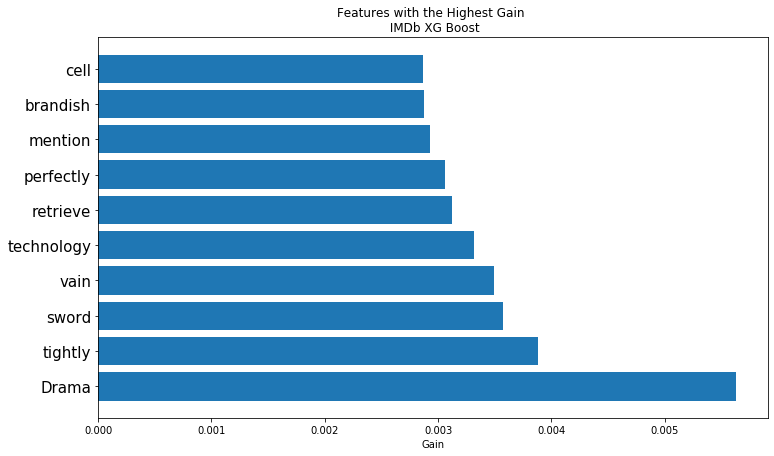

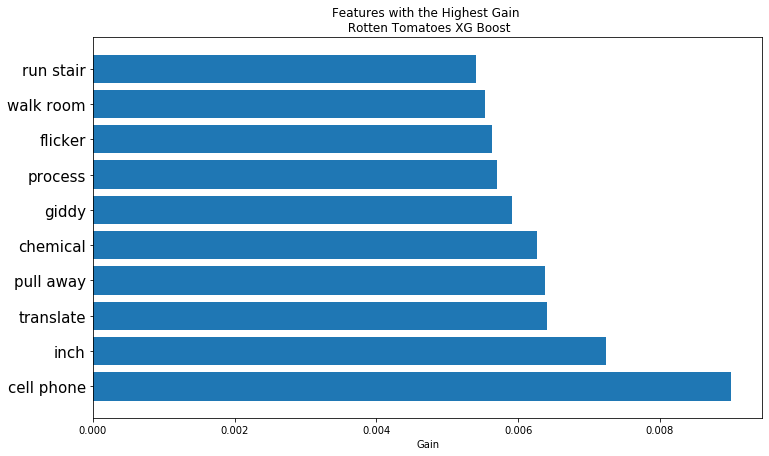

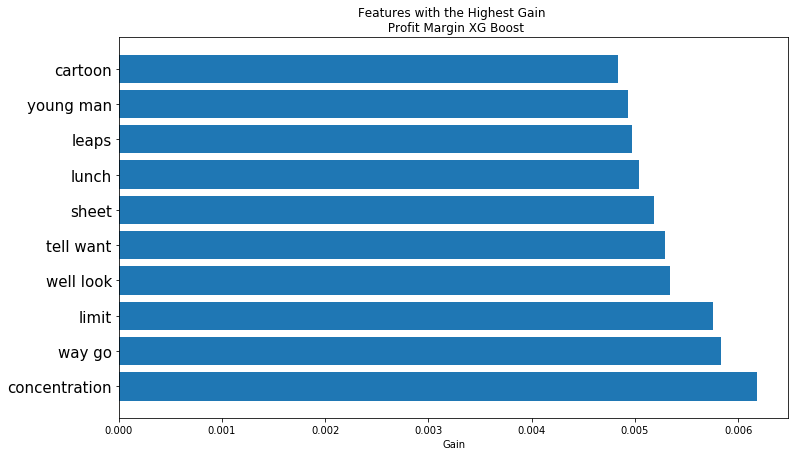

In [165]:
xgbc_scores = xgbc_modeler(targets)

In [166]:
xgbc_scores

[[0.9985528219971056, 0.5930735930735931],
 [1.0, 0.6060606060606061],
 [1.0, 0.5930735930735931]]